In [1]:
import pandas as pd
import numpy as np

from helper_functions import *
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from scipy.stats import expon, uniform

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sample size
n = 1000

# Number of covariates
n_linear = 3
n_non_linear = 3
n_categorical = 3



num_covariates = (n_linear, n_non_linear, n_categorical)

num_latent_group = 3

In [3]:
df = generate_simulated_data(num_sample=n,
                             num_group=num_latent_group,
                             num_covariates=num_covariates,
                             )

In [18]:
categorical_covariates = list(df.columns[n_linear + n_non_linear: n_linear + n_non_linear + n_categorical])

## 1. DCM model

In [19]:
# Data preparation
cleaned_df = df.copy()

# Extract treatment
treatment = cleaned_df["treatment"]

# Names of all categorical features
processed_list = categorical_covariates

# Exclude treatment during the training
cleaned_df.drop("treatment", axis=1, inplace=True)

In [20]:
# Processed data for DCM
X_data_DCM, t_data_DCM, e_data_DCM, categorical_features_list_DCM, numerical_features_list_DCM = (
    processing_data_2_DCM(df=cleaned_df,
                          categorical_features_list=processed_list,
                          train_test_val_size=(0.7, 0.2, 0.1),
                          random_seed=RANDOM_SEED,
                          clustering=False,  # No need to cluster
                          )
)

X_train_DCM, X_val_DCM, X_test_DCM = X_data_DCM
t_train_DCM, t_val_DCM, t_test_DCM = t_data_DCM
e_train_DCM, e_val_DCM, e_test_DCM = e_data_DCM

whole_X_set_DCM = pd.concat([X_train_DCM, X_val_DCM, X_test_DCM], axis=0)
whole_t_set_DCM = pd.concat([t_train_DCM, t_val_DCM, t_test_DCM], axis=0)
whole_e_set_DCM = pd.concat([e_train_DCM, e_val_DCM, e_test_DCM], axis=0)

covariates_DCM = list(whole_X_set_DCM.columns)

# Resample data with IPTW
df_ps_DCM = pd.concat([whole_X_set_DCM, treatment], axis=1)

df_ps_DCM = compute_PS_and_IPTW(df=df_ps_DCM,
                            covariates=covariates_DCM,
                            treatment="treatment")

prob_DCM = df_ps_DCM["iptw_weight"] / df_ps_DCM["iptw_weight"].sum()

resampled_indices_DCM = np.random.choice(len(df_ps_DCM), size=len(df_ps_DCM), replace=True, p=prob_DCM)

x_resampled_DCM = whole_X_set_DCM.values[resampled_indices_DCM]
t_resampled_DCM = whole_t_set_DCM.values[resampled_indices_DCM]
e_resampled_DCM = whole_e_set_DCM.values[resampled_indices_DCM]
treatment_resampled_DCM = treatment.values[resampled_indices_DCM]

x_resampled_df_DCM = pd.DataFrame(x_resampled_DCM, columns=whole_X_set_DCM.columns)
t_resampled_df_DCM = pd.DataFrame(t_resampled_DCM, columns=["time"])
e_resampled_df_DCM = pd.DataFrame(e_resampled_DCM, columns=["event"])
treatment_resampled_df_DCM = pd.DataFrame(treatment_resampled_DCM, columns=["treatment"])

df_resampled_DCM = pd.concat([x_resampled_df_DCM,
                         t_resampled_df_DCM,
                         e_resampled_df_DCM,
                         treatment_resampled_df_DCM],
                        axis=1
                        )

In [21]:
# DCM hyper-parameters
DCM_param_grid = {"k" : [3],
                  "learning_rate" : [1e-3],
                  "layers": [[50, 50]],
                  "iters": [100]
             }
DCM_params = ParameterGrid(DCM_param_grid)

# Define and train DCM model
dcm_wrap = DCM_Wrapper(DCM_params)

dcm_wrap.fit(train_set=[df_resampled_DCM[covariates_DCM],
                        df_resampled_DCM["time"],
                        df_resampled_DCM["event"]]
             )

  0%|          | 0/100 [00:00<?, ?it/s]C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: divide by zero encountered in log
  probs = gates+np.log(event_probs)
C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:105: RuntimeWarning: invalid value encountered in log
  probs = gates+np.log(event_probs)
  5%|▌         | 5/100 [00:00<00:04, 21.77it/s]C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:53: RuntimeWarning: invalid value encountered in power
  s0ts = (-risks)*(spl(ts)**(risks-1))
 30%|███       | 30/100 [00:01<00:02, 23.48it/s]


C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
C:\My_Programs\Python_Project\Causal_Survival_Modeling\Test_Paper\helper_functions.py:464: RuntimeWarning: Mean of empty slice
  S1_avg = np.nanmean(S1, axis=0)
C:\My_Programs\Python_Project\Causal_Survival_Modeling\Test_Paper\helper_functions.py:465: RuntimeWarning: Mean of empty slice
  S0_avg = np.nanmean(S0, axis=0)


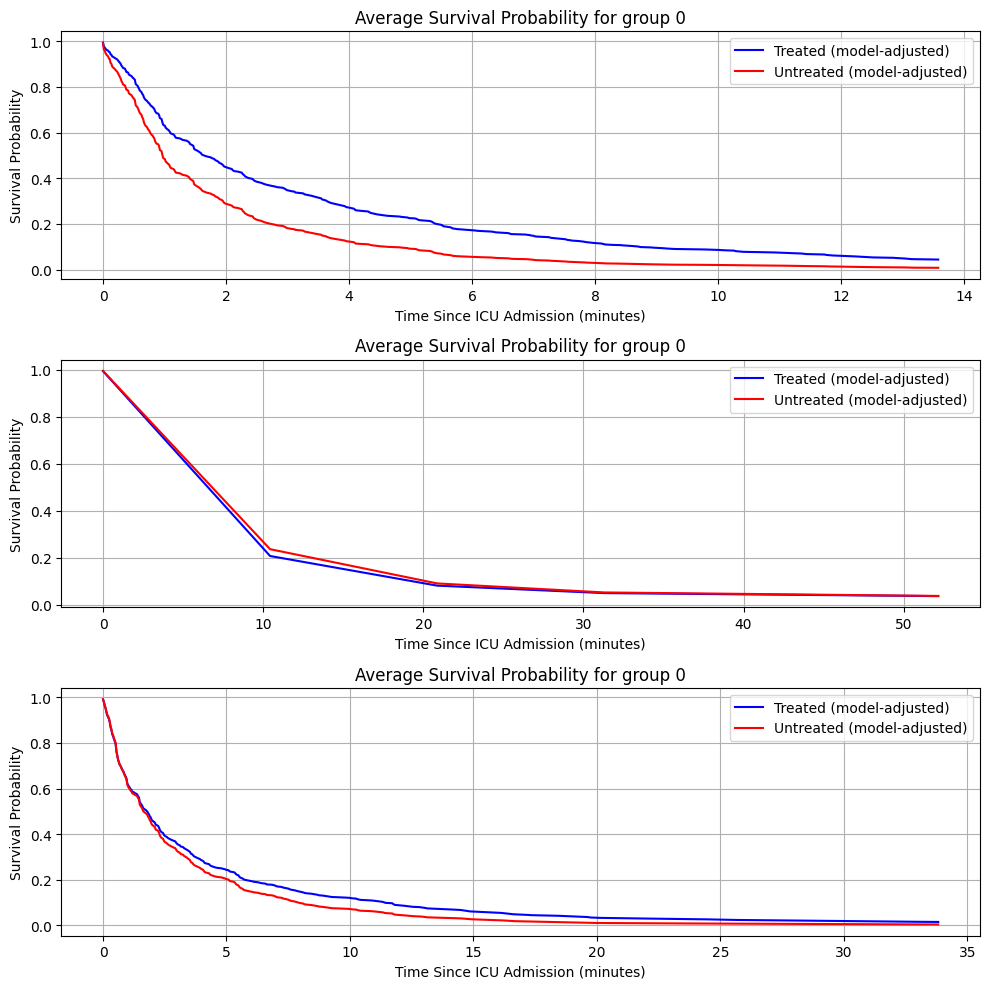

C:\My_Programs\Anaconda\envs\CSMDRMP\lib\site-packages\auton_survival\models\dcm\dcm_utilities.py:58: RuntimeWarning: invalid value encountered in power
  return spl(ts)**risks
C:\My_Programs\Python_Project\Causal_Survival_Modeling\Test_Paper\helper_functions.py:464: RuntimeWarning: Mean of empty slice
  S1_avg = np.nanmean(S1, axis=0)
C:\My_Programs\Python_Project\Causal_Survival_Modeling\Test_Paper\helper_functions.py:465: RuntimeWarning: Mean of empty slice
  S0_avg = np.nanmean(S0, axis=0)


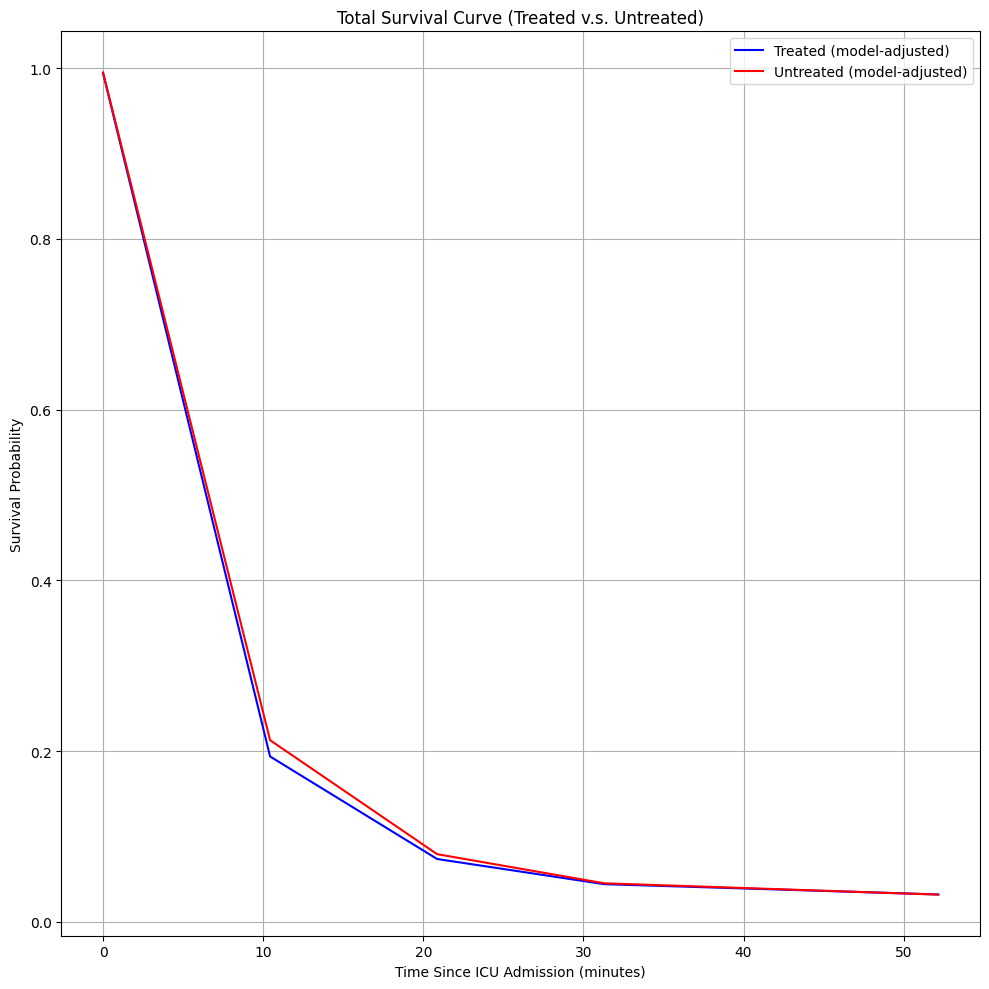

In [22]:
dcm_model = dcm_wrap.model

train_latent_DCM = dcm_model.predict_latent_z(df_resampled_DCM[covariates_DCM])

train_group_DCM = np.argmax(train_latent_DCM, axis=1)

dcm_causal_effects_latent = plot_avg_survival_curve(df=df_resampled_DCM,
                                                    group_index=train_group_DCM,
                                                    model_wrapper=dcm_wrap,
                                                    covariates=covariates_DCM,
                                                    treatment="treatment",
                                                    num_time=1000
                                                    )

dcm_causal_effects_total = plot_avg_survival_curve(df=df_resampled_DCM,
                                                   group_index=np.zeros_like(train_group_DCM),
                                                   model_wrapper=dcm_wrap,
                                                   covariates=covariates_DCM,
                                                   treatment="treatment",
                                                   num_time=1000,
                                                   given_title="Total Survival Curve (Treated v.s. Untreated)"
                                                   )

In [23]:
print(f"DCM model:")
for i, ce in enumerate(dcm_causal_effects_latent):
    print(f"For group {i}, the estimated causal effect: {ce}.")

print(f"Total estimated causal effect: {dcm_causal_effects_total}")

DCM model:
For group 0, the estimated causal effect: 1.3607777960907215.
For group 1, the estimated causal effect: -0.4588605069646672.
For group 2, the estimated causal effect: 0.9268935576358932.
Total estimated causal effect: [-0.2760162593737743]


## 2. DSM model

In [24]:
df_resampled_DSM = df_resampled_DCM
covariates_DSM = covariates_DCM

# DSM hyper-parameters
DSM_param_grid = {"distribution": ["Weibull"],
                  "k": [3],
                  "layers": [[50, 50]],
                  "learning_rate": [1e-3],
                  "iters": [100]
             }
DSM_params = ParameterGrid(DSM_param_grid)

# Define and train DCM model
dsm_wrap = DSM_Wrapper(DSM_params)

dsm_wrap.fit(train_set=[df_resampled_DSM[covariates_DSM],
                        df_resampled_DCM["time"],
                        df_resampled_DSM["event"]]
             )

 31%|███       | 31/100 [00:00<00:01, 41.09it/s]


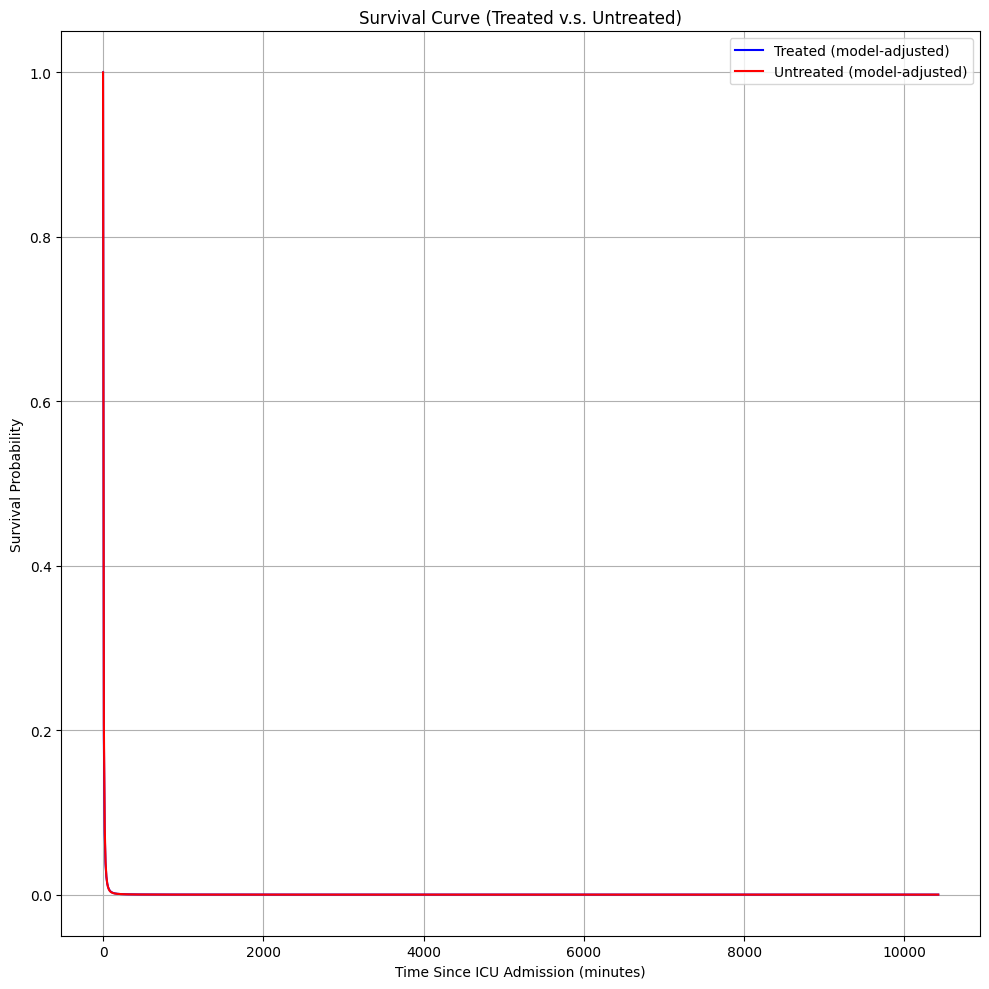

In [25]:
dsm_causal_effects = plot_avg_survival_curve(df=df_resampled_DSM,
                                             group_index=np.zeros_like(train_group_DCM),
                                             model_wrapper=dsm_wrap,
                                             covariates=covariates_DSM,
                                             treatment="treatment",
                                             num_time=1000,
                                             given_title="Survival Curve (Treated v.s. Untreated)"
                                             )

In [26]:
print(f"DSM model: the estimated causal effect: {dsm_causal_effects}.")

DSM model: the estimated causal effect: [-0.025827834387360582].
